In [1]:
import h5py
import pandas as pd
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
from torch.nn import Linear
from torch_geometric.loader import GraphSAINTRandomWalkSampler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.nn import global_mean_pool
import torch_geometric.transforms as T

In [2]:
#LM embeddings for each protein
f = h5py.File('/work/magroup/ehaber/pgm/embeddings.h5', 'r')
#variant labels for pathogenicity
labels = pd.read_csv('/work/magroup/ehaber/pgm/disease_variant_prediction_language_model/data/labels/PTEN_ClinVar_labels.csv')



In [34]:
embeddings_dict = {}
i = 0
for node in (G.nodes):
    if 'HUMAN' in node:
        embeddings_dict[node] = data.x[i]
    i+=1
        
        
proteins_dict = {}
for node in G.nodes:
    if 'HUMAN' in node:
        embedding = torch.from_numpy(f[node][:]).type(torch.float32)
        if embedding.shape[0] > max_len:
            embedding = embedding[:max_len]
        elif embedding.shape[0] < max_len:
            embedding = torch.cat([embedding, torch.zeros(max_len-embedding.shape[0], 1024)])

In [27]:
#only include rows pertaining to proteins of interest
df_net = labels[labels['protein_name'].isin(f.keys())]
#only include columns for protein and variant information
df_net = df_net[['protein_name', 'mutations']]
#assign nodes to type of protein vs variant
def assign_node_types(df):
    types = ['protein', 'variant']
    node_types = {}
    for i, row in df.iterrows():
        node_types[row['protein_name']] = types[0]
        node_types[row['mutations']] = types[1]
    return node_types

nodes = assign_node_types(df_net)
len(nodes)

55

In [13]:
variants_dict = {}
i = 0
for key,val in nodes.items():
    if 'HUMAN' not in key:
        variants_dict[key] = embeddings[i]
        
embeddings_dict = {}
i = 0
for key,val in nodes.items():
    if 'HUMAN' in key:
        embeddings_dict[key] = embeddings[i]

In [125]:
prot_dict = {}
i=0
for k, v in embeddings_dict.items():
    prot_dict[k] = i
    i+=1
prot_dict

{'1433G_HUMAN': 0,
 '2A5D_HUMAN': 1,
 '2AAA_HUMAN': 2,
 '3BP2_HUMAN': 3,
 'A1AT_HUMAN': 4,
 'A4_HUMAN': 5,
 'AAKG2_HUMAN': 6,
 'AATM_HUMAN': 7,
 'ABCBB_HUMAN': 8,
 'ABCD1_HUMAN': 9,
 'ABD12_HUMAN': 10,
 'ABHD5_HUMAN': 11,
 'ACAD9_HUMAN': 12,
 'ACHB_HUMAN': 13,
 'ACHD_HUMAN': 14,
 'ACHE_HUMAN': 15,
 'ACHG_HUMAN': 16,
 'ACOX1_HUMAN': 17,
 'ACTG_HUMAN': 18,
 'ACY2_HUMAN': 19,
 'ADA_HUMAN': 20,
 'ADA2_HUMAN': 21,
 'ADAT3_HUMAN': 22,
 'ADRO_HUMAN': 23,
 'ADT1_HUMAN': 24,
 'AGAL_HUMAN': 25,
 'AGM1_HUMAN': 26,
 'AHI1_HUMAN': 27,
 'AICDA_HUMAN': 28,
 'AIFM1_HUMAN': 29,
 'AIRE_HUMAN': 30,
 'ALAT2_HUMAN': 31,
 'ALDOB_HUMAN': 32,
 'ALG1_HUMAN': 33,
 'ALG11_HUMAN': 34,
 'ALG12_HUMAN': 35,
 'ALG3_HUMAN': 36,
 'ALG6_HUMAN': 37,
 'ALR_HUMAN': 38,
 'ALS_HUMAN': 39,
 'AMACR_HUMAN': 40,
 'AMHR2_HUMAN': 41,
 'AMPD3_HUMAN': 42,
 'ANAG_HUMAN': 43,
 'ANGT_HUMAN': 44,
 'ANKL2_HUMAN': 45,
 'ANO10_HUMAN': 46,
 'ANO5_HUMAN': 47,
 'ANT3_HUMAN': 48,
 'ANTR2_HUMAN': 49,
 'AOFA_HUMAN': 50,
 'AP2A_HUMAN': 51,
 'AP2B

In [128]:
var_idx = {}
i=0
for k, v in variants_dict.items():
    var_idx[k] = i
    i+=1
var_idx

{'D99N': 0,
 'D129E': 1,
 'R132C': 2,
 'R132H': 3,
 'E197K': 4,
 'E198K': 5,
 'E200K': 6,
 'P201R': 7,
 'W207R': 8,
 'D251V': 9,
 'I265L': 10,
 'E420K': 11,
 'P520S': 12,
 'H87Y': 13,
 'V162M': 14,
 'P179L': 15,
 'R182W': 16,
 'R183Q': 17,
 'R183W': 18,
 'A252T': 19,
 'R258H': 20,
 'V27M': 21,
 'R56C': 22,
 'R80Q': 23,
 'H100R': 24,
 'S147L': 25,
 'A155V': 26,
 'L164R': 27,
 'P166L': 28,
 'P215T': 29,
 'P261R': 30,
 'R384Q': 31,
 'R384W': 32,
 'A400T': 33,
 'R415Q': 34,
 'P418L': 35,
 'P418R': 36,
 'P418S': 37,
 'P418T': 38,
 'G420R': 39,
 'S456P': 40,
 'V542M': 41,
 'S60R': 42,
 'R63C': 43,
 'R63L': 44,
 'L65P': 45,
 'H67N': 46,
 'S77F': 47,
 'A82P': 48,
 'E99D': 49,
 'G119V': 50,
 'R125H': 51,
 'Q180E': 52,
 'Y211H': 53,
 'W218C': 54,
 'F222L': 55,
 'Q236R': 56,
 'V237A': 57,
 'P243S': 58,
 'M245I': 59,
 'K246T': 60,
 'G249R': 61,
 'Q254R': 62,
 'L278P': 63,
 'H293R': 64,
 'K298N': 65,
 'E303Q': 66,
 'K334E': 67,
 'N338K': 68,
 'S343A': 69,
 'K355R': 70,
 'D365N': 71,
 'D365Y': 72,
 

In [143]:
labels = labels[labels['mutations'].isin(variants_dict.keys())]
labels = labels[labels['protein_name'].isin(embeddings_dict.keys())]

In [144]:
labels

,protein_name,mutations,ClinVar_labels
0,1433G_HUMAN,D99N,0.0
1,1433G_HUMAN,D129E,1.0
2,1433G_HUMAN,R132C,1.0
3,1433G_HUMAN,R132H,1.0
4,2A5D_HUMAN,E197K,1.0
...,...,...,...
16614,SCN5A_HUMAN,Y1795C,1.0
16615,SCN5A_HUMAN,D1802G,1.0
16616,SCN5A_HUMAN,M1875T,1.0
16617,SCN5A_HUMAN,E1876K,1.0


In [160]:
evol_idx = []
for i, row in labels.iterrows():
    var = labels['mutations'].loc[i]
    prot = labels['protein_name'].loc[i]
    if var in var_idx.keys():
        var_i = var_idx[var]
    if prot in prot_dict.keys():
        prot_i = prot_dict[prot]
        evol_idx.append(log_odds[var_i][prot_i].item())
    


In [159]:
log_odds[var_i][prot_i].item()

-19.956619262695312

In [161]:
labels['evol_indices'] = evol_idx

In [163]:
labels.to_csv('/work/magroup/ehaber/pgm/evol_indices.csv', index=False)


In [ ]:
for i, row in labels.iterrows():
    if row[mutations] in variants_dict.keys():
    

In [111]:
#evolutionary indices
import torch.nn.functional as F

res = []
log_odds = []
for key,val in variants_dict.items():
    variant = val
    prot_lst = torch.zeros(104)
    i = 0
    for prot_k, prot_v in embeddings_dict.items():
        protein = prot_v
        dot_prod = torch.dot(protein.flatten(), variant.flatten())
        prot_lst[i] = dot_prod
        i+=1
    probs = F.softmax(prot_lst, dim=0)
    probs+=1e-45
    res.append(probs)
    log_odds.append(torch.log(probs / (1 - probs)))
    
        
        

In [116]:
res = [-1*logs for logs in log_odds]

In [118]:
len(res)

1967

In [110]:
log_odds

[]

In [64]:
with h5py.File('/work/magroup/ehaber/pgm/gnn_data.h5', 'w') as f:

    # Loop over keys in dictionary
    for key in embeddings_dict.keys():

        # Create a dataset with the same name as the key and fill it with the values from the dictionary
        f.create_dataset(key, data=embeddings_dict[key])

In [66]:
G.nodes()

NodeView(('1433G_HUMAN', 'D99N', 'D129E', 'R132C', 'R132H', '2A5D_HUMAN', 'E197K', 'E198K', 'E200K', 'P201R', 'W207R', 'D251V', 'I265L', 'E420K', 'P520S', '2AAA_HUMAN', 'H87Y', 'V162M', 'P179L', 'R182W', 'R183Q', 'R183W', 'A252T', 'R258H', '3BP2_HUMAN', 'V27M', 'R56C', 'R80Q', 'H100R', 'S147L', 'A155V', 'L164R', 'P166L', 'P215T', 'P261R', 'R384Q', 'R384W', 'A400T', 'R415Q', 'P418L', 'P418R', 'P418S', 'P418T', 'G420R', 'S456P', 'V542M', 'A1AT_HUMAN', 'S60R', 'R63C', 'R63L', 'L65P', 'H67N', 'S77F', 'A82P', 'E99D', 'G119V', 'R125H', 'Q180E', 'Y211H', 'W218C', 'F222L', 'Q236R', 'V237A', 'P243S', 'M245I', 'K246T', 'G249R', 'Q254R', 'L278P', 'H293R', 'K298N', 'E303Q', 'K334E', 'N338K', 'S343A', 'K355R', 'D365N', 'D365Y', 'E366K', 'A374D', 'E378K', 'A379D', 'P393L', 'E400D', 'T403I', 'M409T', 'A4_HUMAN', 'V76I', 'T276S', 'T297M', 'G342S', 'E599K', 'T600M', 'S614G', 'D678H', 'D694N', 'G709S', 'V715M', 'I716V', 'V717F', 'V717I', 'V717L', 'AAKG2_HUMAN', 'F293L', 'R302Q', 'L341S', 'H344Y', 'T400N

In [89]:
embeddings_dict['1433G_HUMAN']

tensor([[-0.0295, -0.0118,  0.0008,  ..., -0.0012,  0.0154,  0.0028],
        [ 0.0257,  0.0370,  0.0028,  ...,  0.0152, -0.0028,  0.0581],
        [-0.0098, -0.0071,  0.0030,  ..., -0.0228,  0.0281,  0.0523],
        ...,
        [-0.0630, -0.0087,  0.0055,  ...,  0.0226, -0.0091,  0.0302],
        [-0.0357,  0.0059, -0.0034,  ...,  0.0503, -0.0587,  0.0126],
        [-0.0684,  0.0191, -0.0228,  ...,  0.0243,  0.0392, -0.0408]])

In [90]:
embeddings_dict['AATM_HUMAN']

tensor([[-0.0295, -0.0118,  0.0008,  ..., -0.0012,  0.0154,  0.0028],
        [ 0.0257,  0.0370,  0.0028,  ...,  0.0152, -0.0028,  0.0581],
        [-0.0098, -0.0071,  0.0030,  ..., -0.0228,  0.0281,  0.0523],
        ...,
        [-0.0630, -0.0087,  0.0055,  ...,  0.0226, -0.0091,  0.0302],
        [-0.0357,  0.0059, -0.0034,  ...,  0.0503, -0.0587,  0.0126],
        [-0.0684,  0.0191, -0.0228,  ...,  0.0243,  0.0392, -0.0408]])

In [72]:
embedding = torch.from_numpy(f['AATM_HUMAN'][:]).type(torch.float32)
embedding

tensor([[ 0.1577, -0.1004, -0.1737,  ...,  0.0887,  0.3196,  0.4382],
        [ 0.1354, -0.0250, -0.1442,  ...,  0.1831,  0.3574, -0.0798],
        [-0.0688, -0.1235, -0.1960,  ...,  0.0593,  0.3940, -0.1526],
        ...,
        [ 0.0818,  0.0321,  0.0615,  ..., -0.2803, -0.0673, -0.0614],
        [-0.0115,  0.1887,  0.2135,  ..., -0.2603, -0.0564,  0.0177],
        [-0.0146,  0.0735,  0.3503,  ..., -0.1267, -0.0264,  0.0481]])

In [70]:
embedding = torch.from_numpy(f['1433G_HUMAN'][:]).type(torch.float32)
embedding

tensor([[ 0.1654, -0.3167,  0.0916,  ...,  0.1343,  0.1927,  0.1815],
        [-0.3940, -0.1548,  0.1377,  ...,  0.1210,  0.1025,  0.2365],
        [-0.0796, -0.1954,  0.0606,  ...,  0.0212, -0.0682, -0.2191],
        ...,
        [ 0.0721, -0.0043,  0.0864,  ..., -0.0131,  0.0029,  0.4216],
        [-0.1675,  0.0114,  0.0873,  ..., -0.3262,  0.1382,  0.5215],
        [-0.1724,  0.0027,  0.2747,  ..., -0.1227,  0.0934,  0.3074]])

In [4]:
#train data

train_nodes = dict(list(nodes.items())[:1656])
val_nodes = dict(list(nodes.items())[1656:])

#create graph
G = nx.Graph()

#add nodes
G.add_nodes_from(train_nodes.keys(), type=train_nodes.values())
#populate graph with columns we are interested in from dataframe
G = nx.from_pandas_edgelist(df_net[df_net['protein_name'].isin(train_nodes.keys())], 'protein_name', 'mutations')

#pad embeddings/truncate
max_len = 700
for node in G.nodes:
    if 'HUMAN' in node:
        embedding = torch.from_numpy(f[node][:]).type(torch.float32)
        if embedding.shape[0] > max_len:
            embedding = embedding[:max_len]
        elif embedding.shape[0] < max_len:
            embedding = torch.cat([embedding, torch.zeros(max_len-embedding.shape[0], 1024)])
        
        embedding = embedding.reshape(-1)
        G.nodes[node]['feat'] = embedding
    else:
        G.nodes[node]['feat'] = torch.randn(max_len, 1024).reshape(-1)
        
train_data = from_networkx(G)


#0 is protein, 1 is variant
node_types = torch.zeros(train_data.num_nodes, dtype=torch.long)
for i, node_type in enumerate(nx.get_node_attributes(G, 'type').values()):
    if node_type == 'protein':
        node_types[i] = 0
    elif node_type == 'variant':
        node_types[i] = 1

train_data.node_type = node_types

train_data.__setattr__('x', train_data.feat)
del train_data.feat

train_data.x = torch.stack(train_data.x)

In [4]:
#val data

train_nodes = dict(list(nodes.items())[:1656])
val_nodes = dict(list(nodes.items())[1656:])

#create graph
G = nx.Graph()

#add nodes
G.add_nodes_from(val_nodes.keys(), type=val_nodes.values())
#populate graph with columns we are interested in from dataframe
G = nx.from_pandas_edgelist(df_net[df_net['protein_name'].isin(val_nodes.keys())], 'protein_name', 'mutations')

#pad embeddings/truncate
max_len = 700
for node in G.nodes:
    if 'HUMAN' in node:
        embedding = torch.from_numpy(f[node][:]).type(torch.float32)
        if embedding.shape[0] > max_len:
            embedding = embedding[:max_len]
        elif embedding.shape[0] < max_len:
            embedding = torch.cat([embedding, torch.zeros(max_len-embedding.shape[0], 1024)])
        
        embedding = embedding.reshape(-1)
        G.nodes[node]['feat'] = embedding
    else:
        G.nodes[node]['feat'] = torch.randn(max_len, 1024).reshape(-1)
        
val_data = from_networkx(G)


#0 is protein, 1 is variant
node_types = torch.zeros(val_data.num_nodes, dtype=torch.long)
for i, node_type in enumerate(nx.get_node_attributes(G, 'type').values()):
    if node_type == 'protein':
        node_types[i] = 0
    elif node_type == 'variant':
        node_types[i] = 1

val_data.node_type = node_types

val_data.__setattr__('x', val_data.feat)
del val_data.feat

val_data.x = torch.stack(val_data.x)

In [17]:
len(nodes)

55

In [28]:
import numpy as np
#create graph
G = nx.DiGraph()

#add nodes
G.add_nodes_from(nodes.keys(), type=nodes.values())
#populate graph with columns we are interested in from dataframe
#G = nx.from_pandas_edgelist(df_net, 'protein_name', 'mutations')
G = nx.from_pandas_edgelist(df_net, source='protein_name', target='mutations')
#pad embeddings/truncate
max_len = 700
for node in G.nodes:
    if 'HUMAN' in node:
        embedding = torch.from_numpy(f[node][:]).type(torch.float32)
        if embedding.shape[0] > max_len:
            embedding = embedding[:max_len]
        elif embedding.shape[0] < max_len:
            embedding = torch.cat([embedding, torch.zeros(max_len-embedding.shape[0], 1024)])
        
#         embedding = embedding.reshape(-1)
        G.nodes[node]['feat'] = embedding
    else:
        G.nodes[node]['feat'] = torch.randn(max_len, 1024)
#         G.nodes[node]['feat'] = torch.randn(max_len, 1024).reshape(-1)

In [29]:
data = from_networkx(G)


#0 is protein, 1 is variant
node_types = torch.zeros(data.num_nodes, dtype=torch.long)
for i, node_type in enumerate(nx.get_node_attributes(G, 'type').values()):
    if node_type == 'protein':
        node_types[i] = 0
    elif node_type == 'variant':
        node_types[i] = 1

data.node_type = node_types

data.__setattr__('x', data.feat)
del data.feat


In [6]:
print("Edge Index:", data.edge_index)
print("Node Features:", data.x)
print("Node type:", data.node_type)

Edge Index: tensor([[   0,    0,    0,  ..., 2068, 2069, 2070],
        [   1,    2,    3,  ..., 1971, 1971, 1971]])
Node Features: [tensor([[ 0.1654, -0.3167,  0.0916,  ...,  0.1343,  0.1927,  0.1815],
        [-0.3940, -0.1548,  0.1377,  ...,  0.1210,  0.1025,  0.2365],
        [-0.0796, -0.1954,  0.0606,  ...,  0.0212, -0.0682, -0.2191],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([[-1.0952,  1.1367,  0.9014,  ...,  0.2776,  0.9722,  0.4646],
        [-0.4678,  0.4566, -0.9420,  ...,  0.0068,  0.0132,  0.0246],
        [-0.2788, -1.0323,  0.2823,  ...,  1.1508, -0.2789, -0.8440],
        ...,
        [-0.4587,  0.4904,  0.9010,  ..., -0.3497, -0.1984, -0.6501],
        [-0.6045, -0.4772, -0.3390,  ..., -0.6992, -1.9463, -0.3734],
        [-0.7651, -1.5878,  0.2146,  ..., -1.5524,  0.0613,  1.8544]]

In [6]:
data.x = torch.stack(data.x)

In [23]:
G.nodes()

NodeView(('1433G_HUMAN', 'D99N', 'D129E', 'R132C', 'R132H', '2A5D_HUMAN', 'E197K', 'E198K', 'E200K', 'P201R', 'W207R', 'D251V', 'I265L', 'E420K', 'P520S', '2AAA_HUMAN', 'H87Y', 'V162M', 'P179L', 'R182W', 'R183Q', 'R183W', 'A252T', 'R258H', '3BP2_HUMAN', 'V27M', 'R56C', 'R80Q', 'H100R', 'S147L', 'A155V', 'L164R', 'P166L', 'P215T', 'P261R', 'R384Q', 'R384W', 'A400T', 'R415Q', 'P418L', 'P418R', 'P418S', 'P418T', 'G420R', 'S456P', 'V542M', 'A1AT_HUMAN', 'S60R', 'R63C', 'R63L', 'L65P', 'H67N', 'S77F', 'A82P', 'E99D', 'G119V', 'R125H', 'Q180E', 'Y211H', 'W218C', 'F222L', 'Q236R', 'V237A', 'P243S', 'M245I', 'K246T', 'G249R', 'Q254R', 'L278P', 'H293R', 'K298N', 'E303Q', 'K334E', 'N338K', 'S343A', 'K355R', 'D365N', 'D365Y', 'E366K', 'A374D', 'E378K', 'A379D', 'P393L', 'E400D', 'T403I', 'M409T', 'A4_HUMAN', 'V76I', 'T276S', 'T297M', 'G342S', 'E599K', 'T600M', 'S614G', 'D678H', 'D694N', 'G709S', 'V715M', 'I716V', 'V717F', 'V717I', 'V717L', 'AAKG2_HUMAN', 'F293L', 'R302Q', 'L341S', 'H344Y', 'T400N

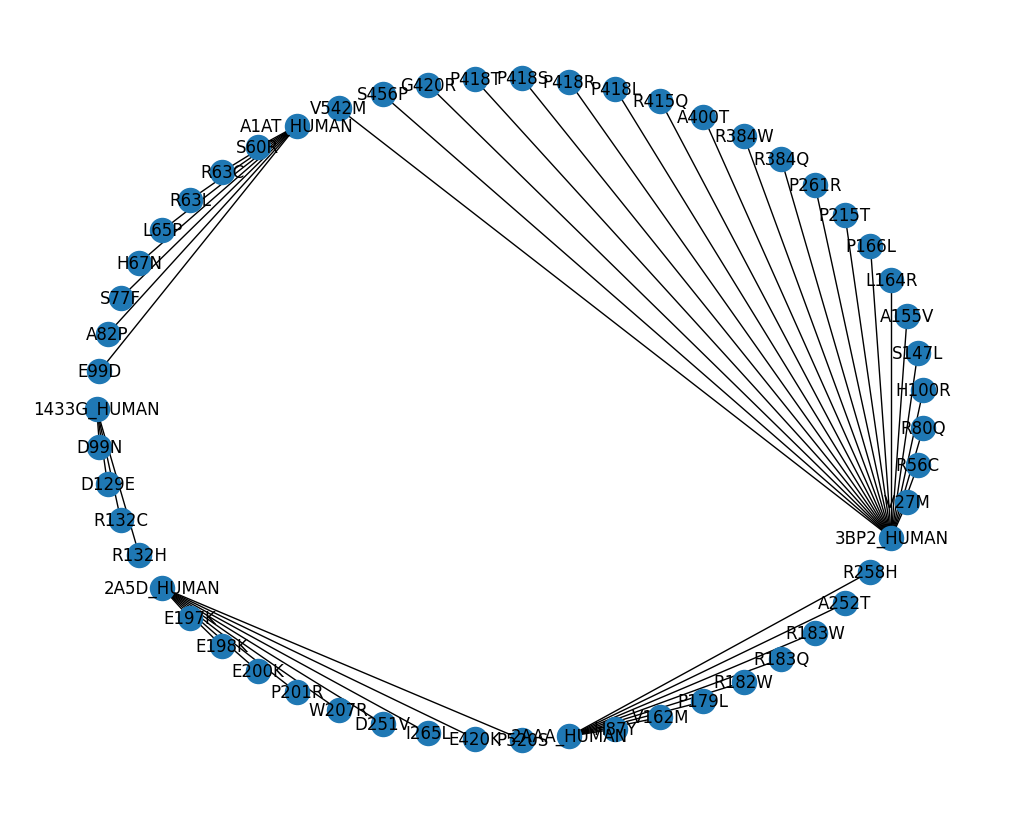

In [30]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [168]:
data.x = torch.stack(data.x)

In [148]:
node_dict = {}
i = 0
for node in G.nodes:
    node_dict[node] = i
    i+=1

In [10]:
import torch_geometric.nn as pyg_nn
from torch_geometric.nn import MessagePassing

dataset=data
# Define the hyperparameters
# input_dim = 716800
input_dim=1024
hidden_dim = 128
num_layers = 4
lr = 0.001
epochs = 100
out_dim = 1024
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree




class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.5):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convn = GCNConv(hidden_dim, input_dim)
        self.dropout = dropout

    def forward(self, x, edge_index, node_type):
        x = x.to(device)
        edge_index = edge_index.to(device)
        node_type = node_type.to(device)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convn(x, edge_index)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model and optimizer
model = GNN(input_dim, hidden_dim, num_layers).to(device)
#model = Net(input_dim, hidden_dim, out_dim).to(device)

#model = to_hetero(model, data.metadata(), aggr='sum')

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the number of subgraphs to sample
num_subgraphs = 20

# Define the length of each random walk
walk_length = 10

# Define the number of hops to make in each random walk
num_hops = 3

# Define the batch size
batch_size = 16

# Create the GraphSAINTRandomWalkSampler
sampler = GraphSAINTRandomWalkSampler(data, num_subgraphs, walk_length, num_hops, batch_size)




# # Loop through the sampler to get batches of subgraphs
model.train()
# Training loop
for epoch in range(50):
    total_loss = 0
    for batch in sampler:
        batch = batch.to(device)
        optimizer.zero_grad()
#         print(batch.src_nodes)
#         print(batch.edge_index[0])
        out = model(batch.x, batch.edge_index, batch.node_type)
        #loss = F.cross_entropy(out, batch.y)
        loss = F.mse_loss(out, batch.x)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()  # track loss for entire batch
        del batch, out, loss

    print(f"Epoch {epoch}, Loss: {total_loss / len(dataset)}")
    
# Get the learned embeddings

Compute GraphSAINT normalization: : 33208it [00:00, 468274.31it/s]                                    


Epoch 0, Loss: 0.8251604735851288
Epoch 1, Loss: 0.7271171808242798
Epoch 2, Loss: 0.6898373663425446
Epoch 3, Loss: 0.6727036386728287
Epoch 4, Loss: 0.6674911081790924
Epoch 5, Loss: 0.6598161607980728
Epoch 6, Loss: 0.6526345163583755
Epoch 7, Loss: 0.6556703001260757
Epoch 8, Loss: 0.642627939581871
Epoch 9, Loss: 0.648464024066925
Epoch 10, Loss: 0.6498413980007172
Epoch 11, Loss: 0.656975507736206
Epoch 12, Loss: 0.6517914831638336
Epoch 13, Loss: 0.6490698158740997
Epoch 14, Loss: 0.635829821228981
Epoch 15, Loss: 0.6505505293607712
Epoch 16, Loss: 0.6470605134963989
Epoch 17, Loss: 0.6450229585170746
Epoch 18, Loss: 0.6494971811771393
Epoch 19, Loss: 0.6445694118738174
Epoch 20, Loss: 0.6402879506349564
Epoch 21, Loss: 0.654721811413765
Epoch 22, Loss: 0.655069887638092
Epoch 23, Loss: 0.6581557840108871
Epoch 24, Loss: 0.6369359195232391
Epoch 25, Loss: 0.6353340744972229
Epoch 26, Loss: 0.646917998790741
Epoch 27, Loss: 0.6424488723278046
Epoch 28, Loss: 0.6397849023342133
Ep

In [179]:
batch

Data(num_nodes=114, edge_index=[2, 194], node_type=[114], x=[114, 716800], src_nodes=[194], dst_nodes=[194], node_norm=[114], edge_norm=[194])

In [178]:
batch.x.reshape(-1, 1024).shape

torch.Size([79800, 1024])

In [12]:
#Generate embeddings from GNN
cluster_data = ClusterData(dataset, 80)

# Create a ClusterLoader object to load the subgraphs in batches
batch_size = 8
cluster_loader = ClusterLoader(cluster_data, batch_size=batch_size, shuffle=True)

model.eval()
with torch.no_grad():
    embeddings = []
    for batch in cluster_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.node_type)
        embeddings.append(out.cpu().detach())
        del batch, out
    embeddings = torch.cat(embeddings, dim=0)
    
embeddings = embeddings.view(2071, 700, 1024)

Computing METIS partitioning...
Done!


In [82]:
data.edge_index.t()

tensor([[   0,    1],
        [   0,    2],
        [   0,    3],
        ...,
        [2068, 1971],
        [2069, 1971],
        [2070, 1971]])

In [14]:
torch.divide(torch.sum(pred),len(pred))

tensor(146457.6250, device='cuda:0')

In [15]:
torch.sum(pred)

tensor(11863068, device='cuda:0')

In [8]:
from sklearn.model_selection import ParameterGrid
from torch import optim
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_auc_score

param_grid = {
    'hidden_channels': [16, 32, 64],
    'num_layers': [2, 3, 4],
    'lr': [0.001, 0.01, 0.1]
}

model = GNN(input_dim, hidden_dim, num_layers).to(device)
sampler = GraphSAINTRandomWalkSampler(train_data, num_subgraphs, walk_length, num_hops, batch_size)


train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=4)



results = []
for params in ParameterGrid(param_grid):

    # Define the GNN model with the current set of hyperparameters
    model = GNN(input_dim, params['hidden_channels'], num_layers=params['num_layers']).to(device)

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Train the GNN model


    model.train()
    for epoch in range(50):
        total_loss = 0
        for batch in sampler:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.node_type)
            loss = F.mse_loss(out, batch.x)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()  # track loss for entire batch
            del batch, out, loss
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_data)}")
            
            
    


    cluster_data = ClusterData(val_data, 20)

    # Create a ClusterLoader object to load the subgraphs in batches
    batch_size = 8
    cluster_loader = ClusterLoader(cluster_data, batch_size=batch_size, shuffle=True)

    model.eval()
    with torch.no_grad():
        for batch in cluster_loader:
            out = model(batch.x, batch.edge_index, batch.node_type)
            pred = out.argmax(dim=1)
            acc = pred.sum().item() / len(pred)
            print(acc)
            del batch, out
    
    


Compute GraphSAINT normalization: : 13661it [00:00, 523502.42it/s]                                    


Epoch 0, Loss: 0.6358310580253601
Epoch 1, Loss: 0.6408772021532059
Epoch 2, Loss: 0.646835133433342
Epoch 3, Loss: 0.6522227674722672
Epoch 4, Loss: 0.6495609730482101
Epoch 5, Loss: 0.6286749392747879
Epoch 6, Loss: 0.6352733373641968
Epoch 7, Loss: 0.6364413797855377
Epoch 8, Loss: 0.6702963560819626
Epoch 9, Loss: 0.6495024561882019
Epoch 10, Loss: 0.6750147044658661
Epoch 11, Loss: 0.6474777162075043
Epoch 12, Loss: 0.6429168581962585
Epoch 13, Loss: 0.637299507856369
Epoch 14, Loss: 0.6410452872514725
Epoch 15, Loss: 0.6437313854694366
Epoch 16, Loss: 0.644647866487503
Epoch 17, Loss: 0.6457767337560654
Epoch 18, Loss: 0.6370540857315063
Epoch 19, Loss: 0.6346985101699829
Epoch 20, Loss: 0.6486603766679764
Epoch 21, Loss: 0.6379394382238388
Epoch 22, Loss: 0.6404774338006973
Epoch 23, Loss: 0.6388826221227646
Epoch 24, Loss: 0.6380511075258255
Epoch 25, Loss: 0.6633534729480743
Epoch 26, Loss: 0.6364929974079132
Epoch 27, Loss: 0.6441233307123184
Epoch 28, Loss: 0.647998094558715

Computing METIS partitioning...
Done!


83748.39759036145
82500.7212121212
170758.43209876542
Epoch 0, Loss: 0.6386744529008865
Epoch 1, Loss: 0.6359615176916122
Epoch 2, Loss: 0.6464515179395676
Epoch 3, Loss: 0.6475332081317902
Epoch 4, Loss: 0.6450159102678299
Epoch 5, Loss: 0.658493161201477
Epoch 6, Loss: 0.6519410759210587
Epoch 7, Loss: 0.6494829207658768
Epoch 8, Loss: 0.6424573063850403
Epoch 9, Loss: 0.6406304240226746
Epoch 10, Loss: 0.6461119055747986
Epoch 11, Loss: 0.6553161442279816
Epoch 12, Loss: 0.6553515195846558
Epoch 13, Loss: 0.6327799558639526
Epoch 14, Loss: 0.655301421880722
Epoch 15, Loss: 0.6495687961578369
Epoch 16, Loss: 0.6403932869434357
Epoch 17, Loss: 0.6304214000701904
Epoch 18, Loss: 0.6401409655809402
Epoch 19, Loss: 0.6503153741359711
Epoch 20, Loss: 0.6380350291728973
Epoch 21, Loss: 0.6436907202005386
Epoch 22, Loss: 0.6499766856431961
Epoch 23, Loss: 0.6399191170930862
Epoch 24, Loss: 0.6497332006692886
Epoch 25, Loss: 0.6435610800981522
Epoch 26, Loss: 0.6439238339662552
Epoch 27, Los

Computing METIS partitioning...
Done!


68817.71604938271
207912.56097560975
141374.4534883721
Epoch 0, Loss: 0.6334034651517868
Epoch 1, Loss: 0.6392019987106323
Epoch 2, Loss: 0.6435731053352356
Epoch 3, Loss: 0.6452338844537735
Epoch 4, Loss: 0.6427276283502579
Epoch 5, Loss: 0.6543271243572235
Epoch 6, Loss: 0.6438878327608109
Epoch 7, Loss: 0.6516827344894409
Epoch 8, Loss: 0.6418028622865677
Epoch 9, Loss: 0.6386521607637405
Epoch 10, Loss: 0.6391065567731857
Epoch 11, Loss: 0.6494261473417282
Epoch 12, Loss: 0.6454169452190399
Epoch 13, Loss: 0.6421220451593399
Epoch 14, Loss: 0.6515117287635803
Epoch 15, Loss: 0.6429819166660309
Epoch 16, Loss: 0.6333378702402115
Epoch 17, Loss: 0.6355504095554352
Epoch 18, Loss: 0.6397500038146973
Epoch 19, Loss: 0.6354227960109711
Epoch 20, Loss: 0.650923565030098
Epoch 21, Loss: 0.6437210440635681
Epoch 22, Loss: 0.6391840726137161
Epoch 23, Loss: 0.6377844512462616
Epoch 24, Loss: 0.6380043178796768
Epoch 25, Loss: 0.6353770047426224
Epoch 26, Loss: 0.6466618627309799
Epoch 27, L

Computing METIS partitioning...
Done!


96366.78787878787
45381.89156626506
Epoch 0, Loss: 0.7979565262794495
Epoch 1, Loss: 0.7494126558303833
Epoch 2, Loss: 0.8482527285814285
Epoch 3, Loss: 1.8644204139709473
Epoch 4, Loss: 3.935767889022827
Epoch 5, Loss: 7.647714197635651
Epoch 6, Loss: 4.914599031209946
Epoch 7, Loss: 21.92285794019699
Epoch 8, Loss: 3.583592787384987
Epoch 9, Loss: 52.615602016448975
Epoch 10, Loss: 23.56118394434452
Epoch 11, Loss: 173.79800152778625
Epoch 12, Loss: 180.53020268678665
Epoch 13, Loss: 19.73841953277588
Epoch 14, Loss: 3.4718066453933716
Epoch 15, Loss: 41.03097426891327
Epoch 16, Loss: 449.5433430969715
Epoch 17, Loss: 3.0218085646629333
Epoch 18, Loss: 52.536358296871185
Epoch 19, Loss: 221.85858684778214
Epoch 20, Loss: 160.05387389659882
Epoch 21, Loss: 22.1106598675251
Epoch 22, Loss: 4.894605219364166
Epoch 23, Loss: 1.4348006844520569
Epoch 24, Loss: 171.34946238994598
Epoch 25, Loss: 1.0638807117938995
Epoch 26, Loss: 29.957418709993362
Epoch 27, Loss: 13.829676419496536
Epoch 

Computing METIS partitioning...
Done!


347608.75
407496.18902439025
371190.3214285714
Epoch 0, Loss: 0.8794505745172501
Epoch 1, Loss: 2.4211305677890778
Epoch 2, Loss: 1.9559484720230103
Epoch 3, Loss: 4.590205520391464
Epoch 4, Loss: 1.6864542365074158
Epoch 5, Loss: 6.707645118236542
Epoch 6, Loss: 5.221188902854919
Epoch 7, Loss: 27.707271337509155
Epoch 8, Loss: 7.716761231422424
Epoch 9, Loss: 17.922923684120178
Epoch 10, Loss: 29.522942066192627
Epoch 11, Loss: 24.11975336074829
Epoch 12, Loss: 9.534726679325104
Epoch 13, Loss: 7.47818386554718
Epoch 14, Loss: 5.910990417003632
Epoch 15, Loss: 5.151457339525223
Epoch 16, Loss: 6.104123055934906
Epoch 17, Loss: 3.047274351119995
Epoch 18, Loss: 6.220376193523407
Epoch 19, Loss: 2.015858441591263
Epoch 20, Loss: 1.314528077840805
Epoch 21, Loss: 2.4997487664222717
Epoch 22, Loss: 2.5302687883377075
Epoch 23, Loss: 2.865537643432617
Epoch 24, Loss: 1.3929545283317566
Epoch 25, Loss: 4.895243421196938
Epoch 26, Loss: 1.9183030724525452
Epoch 27, Loss: 0.853163942694664
E

Computing METIS partitioning...
Done!


516191.9079754601
540125.3293413174
568494.0731707317
Epoch 0, Loss: 1.1968953609466553
Epoch 1, Loss: 1.259450763463974
Epoch 2, Loss: 2.2821141183376312
Epoch 3, Loss: 13.4695785343647
Epoch 4, Loss: 7.493739008903503
Epoch 5, Loss: 0.9742385447025299
Epoch 6, Loss: 2.790577232837677
Epoch 7, Loss: 14.264747023582458
Epoch 8, Loss: 1.485095053911209
Epoch 9, Loss: 1.1098502576351166
Epoch 10, Loss: 4.280762553215027
Epoch 11, Loss: 3.806758016347885
Epoch 12, Loss: 3.714068591594696
Epoch 13, Loss: 1.5575029850006104
Epoch 14, Loss: 1.265514999628067
Epoch 15, Loss: 1.4727724492549896
Epoch 16, Loss: 1.9513401687145233
Epoch 17, Loss: 6.84456467628479
Epoch 18, Loss: 0.9177658259868622
Epoch 19, Loss: 1.18768110871315
Epoch 20, Loss: 0.8833235651254654
Epoch 21, Loss: 0.695052295923233
Epoch 22, Loss: 0.7220504730939865
Epoch 23, Loss: 0.7143706977367401
Epoch 24, Loss: 0.7566648572683334
Epoch 25, Loss: 0.6755834221839905
Epoch 26, Loss: 0.8178474009037018
Epoch 27, Loss: 0.66101898

Computing METIS partitioning...
Done!


314572.7696969697
319589.9693251534
301654.25
Epoch 0, Loss: 1165.5793568342924
Epoch 1, Loss: 287.9704189300537
Epoch 2, Loss: 1721.173625946045
Epoch 3, Loss: 181906.5827140808
Epoch 4, Loss: 4143.718719482422
Epoch 5, Loss: 2278.6106567382812
Epoch 6, Loss: 9079.558471679688
Epoch 7, Loss: 292808.837890625
Epoch 8, Loss: 41457.10974121094
Epoch 9, Loss: 396002.26989746094
Epoch 10, Loss: 11304.704330444336
Epoch 11, Loss: 285583.8914794922
Epoch 12, Loss: 333602.7421875
Epoch 13, Loss: 242860.95703125
Epoch 14, Loss: 4902805.253417969
Epoch 15, Loss: 1015729.9903564453
Epoch 16, Loss: 14196234.12109375
Epoch 17, Loss: 38364.325927734375
Epoch 18, Loss: 98045.7001953125
Epoch 19, Loss: 157066.6527709961
Epoch 20, Loss: 164029.080078125
Epoch 21, Loss: 48010.90771484375
Epoch 22, Loss: 1113169.124633789
Epoch 23, Loss: 93131.2587890625
Epoch 24, Loss: 35269393.62548828
Epoch 25, Loss: 1852535.296875
Epoch 26, Loss: 24476376.38232422
Epoch 27, Loss: 10856395.95336914
Epoch 28, Loss: 62

Computing METIS partitioning...
Done!


308336.3614457831
337553.4819277108
Epoch 0, Loss: 3374.2685832232237
Epoch 1, Loss: 67.9851643294096
Epoch 2, Loss: 0.6720823049545288
Epoch 3, Loss: 1.32726389169693
Epoch 4, Loss: 0.7087073028087616
Epoch 5, Loss: 0.7082484811544418
Epoch 6, Loss: 0.7200784683227539
Epoch 7, Loss: 0.7110005915164948
Epoch 8, Loss: 0.7142388373613358
Epoch 9, Loss: 0.7136048078536987
Epoch 10, Loss: 257.18794545531273
Epoch 11, Loss: 0.6925549209117889
Epoch 12, Loss: 0.6833482384681702
Epoch 13, Loss: 0.6719827950000763
Epoch 14, Loss: 0.6812974959611893
Epoch 15, Loss: 0.6713379770517349
Epoch 16, Loss: 0.6712122559547424
Epoch 17, Loss: 0.6626593917608261
Epoch 18, Loss: 0.6572935730218887
Epoch 19, Loss: 0.6613510549068451
Epoch 20, Loss: 0.6506608128547668
Epoch 21, Loss: 0.6574163734912872
Epoch 22, Loss: 0.6447370946407318
Epoch 23, Loss: 0.6521266996860504
Epoch 24, Loss: 0.648761123418808
Epoch 25, Loss: 0.643705889582634
Epoch 26, Loss: 0.6441145241260529
Epoch 27, Loss: 0.6449709981679916


Computing METIS partitioning...
Done!


15019.0
15019.0
15019.0
Epoch 0, Loss: 12.356165245175362
Epoch 1, Loss: 0.6575733125209808
Epoch 2, Loss: 0.6712255328893661
Epoch 3, Loss: 0.6644755005836487
Epoch 4, Loss: 0.6622788906097412
Epoch 5, Loss: 0.6689165979623795
Epoch 6, Loss: 0.6454318761825562
Epoch 7, Loss: 0.653706431388855
Epoch 8, Loss: 0.6370305567979813
Epoch 9, Loss: 0.6505373120307922
Epoch 10, Loss: 0.6421885043382645
Epoch 11, Loss: 0.647129237651825
Epoch 12, Loss: 0.6501237004995346
Epoch 13, Loss: 0.6434832215309143
Epoch 14, Loss: 0.6397944092750549
Epoch 15, Loss: 0.6529876589775085
Epoch 16, Loss: 0.6490144729614258
Epoch 17, Loss: 0.6405099183320999
Epoch 18, Loss: 0.6390789449214935
Epoch 19, Loss: 0.6411143243312836
Epoch 20, Loss: 0.6463736444711685
Epoch 21, Loss: 0.6431033313274384
Epoch 22, Loss: 0.6479118913412094
Epoch 23, Loss: 0.6471244841814041
Epoch 24, Loss: 0.6422731876373291
Epoch 25, Loss: 0.6576082110404968
Epoch 26, Loss: 0.6386274099349976
Epoch 27, Loss: 0.6382824182510376
Epoch 28

Computing METIS partitioning...
Done!


204637.0
204637.0
204637.0
Epoch 0, Loss: 0.6443057209253311
Epoch 1, Loss: 0.6493428200483322
Epoch 2, Loss: 0.6379578411579132
Epoch 3, Loss: 0.6496732234954834
Epoch 4, Loss: 0.6481987684965134
Epoch 5, Loss: 0.6383630186319351
Epoch 6, Loss: 0.6608681827783585
Epoch 7, Loss: 0.6474681496620178
Epoch 8, Loss: 0.634838730096817
Epoch 9, Loss: 0.6511281281709671
Epoch 10, Loss: 0.6452789157629013
Epoch 11, Loss: 0.6577869653701782
Epoch 12, Loss: 0.6423950642347336
Epoch 13, Loss: 0.6346118897199631
Epoch 14, Loss: 0.6392862647771835
Epoch 15, Loss: 0.6508607715368271
Epoch 16, Loss: 0.6573008447885513
Epoch 17, Loss: 0.6489208340644836
Epoch 18, Loss: 0.6349648386240005
Epoch 19, Loss: 0.6448300778865814
Epoch 20, Loss: 0.6414955407381058
Epoch 21, Loss: 0.6401695758104324
Epoch 22, Loss: 0.6422536224126816
Epoch 23, Loss: 0.6429650634527206
Epoch 24, Loss: 0.6377842873334885
Epoch 25, Loss: 0.6388625353574753
Epoch 26, Loss: 0.6388485431671143
Epoch 27, Loss: 0.6397791355848312
Epoc

Computing METIS partitioning...
Done!


52869.07878787879
44969.72289156626
96870.18518518518
Epoch 0, Loss: 0.6395396441221237
Epoch 1, Loss: 0.6416810601949692
Epoch 2, Loss: 0.6463170498609543
Epoch 3, Loss: 0.6648979187011719
Epoch 4, Loss: 0.6421273946762085
Epoch 5, Loss: 0.654749408364296
Epoch 6, Loss: 0.6635919213294983
Epoch 7, Loss: 0.6526164263486862
Epoch 8, Loss: 0.6463531255722046
Epoch 9, Loss: 0.6517200469970703
Epoch 10, Loss: 0.6496051996946335
Epoch 11, Loss: 0.6465325206518173
Epoch 12, Loss: 0.6457251012325287
Epoch 13, Loss: 0.6486557573080063
Epoch 14, Loss: 0.6522179543972015
Epoch 15, Loss: 0.6482031643390656
Epoch 16, Loss: 0.6455141305923462
Epoch 17, Loss: 0.6608200073242188
Epoch 18, Loss: 0.6424154043197632
Epoch 19, Loss: 0.6467005461454391
Epoch 20, Loss: 0.6397053599357605
Epoch 21, Loss: 0.649692639708519
Epoch 22, Loss: 0.6456333845853806
Epoch 23, Loss: 0.6446507126092911
Epoch 24, Loss: 0.6523482799530029
Epoch 25, Loss: 0.6475480943918228
Epoch 26, Loss: 0.6391422003507614
Epoch 27, Los

Computing METIS partitioning...
Done!


147806.50898203594
259606.3963414634
146457.62962962964
Epoch 0, Loss: 0.641987070441246
Epoch 1, Loss: 0.6433923244476318
Epoch 2, Loss: 0.6429969668388367
Epoch 3, Loss: 0.6481492072343826
Epoch 4, Loss: 0.6476588696241379
Epoch 5, Loss: 0.6521875858306885
Epoch 6, Loss: 0.6473035961389542
Epoch 7, Loss: 0.6529357433319092
Epoch 8, Loss: 0.6365500390529633
Epoch 9, Loss: 0.6450485587120056
Epoch 10, Loss: 0.6507875323295593
Epoch 11, Loss: 0.6422313004732132
Epoch 12, Loss: 0.6551815420389175
Epoch 13, Loss: 0.650437518954277
Epoch 14, Loss: 0.6438205689191818
Epoch 15, Loss: 0.6465721130371094
Epoch 16, Loss: 0.6424374580383301
Epoch 17, Loss: 0.6562394201755524


KeyboardInterrupt: 

In [38]:
val_data

Data(edge_index=[2, 814], num_nodes=412, node_type=[412], x=[412, 716800])

In [34]:
torch.save(model.state_dict(), '/work/magroup/ehaber/pgm/gnn.pth')


In [15]:
# model.eval()
# with torch.no_grad():
#     dataset.x = dataset.x.to('cpu')
#     dataset.edge_index = dataset.edge_index.to('cpu')
#     out = model(dataset.x, dataset.edge_index).cpu()

In [15]:
model = GNN(input_dim, hidden_dim, num_layers).to(device)

model = model.load_state_dict(torch.load('/work/magroup/ehaber/pgm/gnn.pth'))


In [18]:
model.eval()
with torch.no_grad():
    embeddings = []
    for batch in cluster_loader:
        out = model(batch.x, batch.edge_index, batch.node_type)
        embeddings.append(out.cpu().detach())
        del batch, out
    embeddings = torch.cat(embeddings, dim=0)
    
embeddings = embeddings.view(2071, 700, 1024)

In [12]:
embeddings.shape

torch.Size([2071, 700, 1024])

In [21]:
dataset

Data(edge_index=[2, 4000], num_nodes=2071, x=[2071, 716800])

In [43]:
with torch.no_grad():
    edge_index = dataset.edge_index
    embeddings = model(dataset.x, edge_index)

RuntimeError: CUDA out of memory. Tried to allocate 1.58 GiB (GPU 0; 10.76 GiB total capacity; 8.80 GiB already allocated; 783.44 MiB free; 8.98 GiB reserved in total by PyTorch)

In [24]:
# Create an h5 file
with h5py.File('/work/magroup/ehaber/pgm/gnn_data_final.h5', 'w') as f:
    # Create a dataset in the h5 file
    dset = f.create_dataset('data', data=embeddings.numpy())


In [39]:
embeddings = embeddings.view(2071, 700, 1024)

In [13]:
print(torch.__version__)


2.0.0


/home/ehaber/miniconda3/envs/popari/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


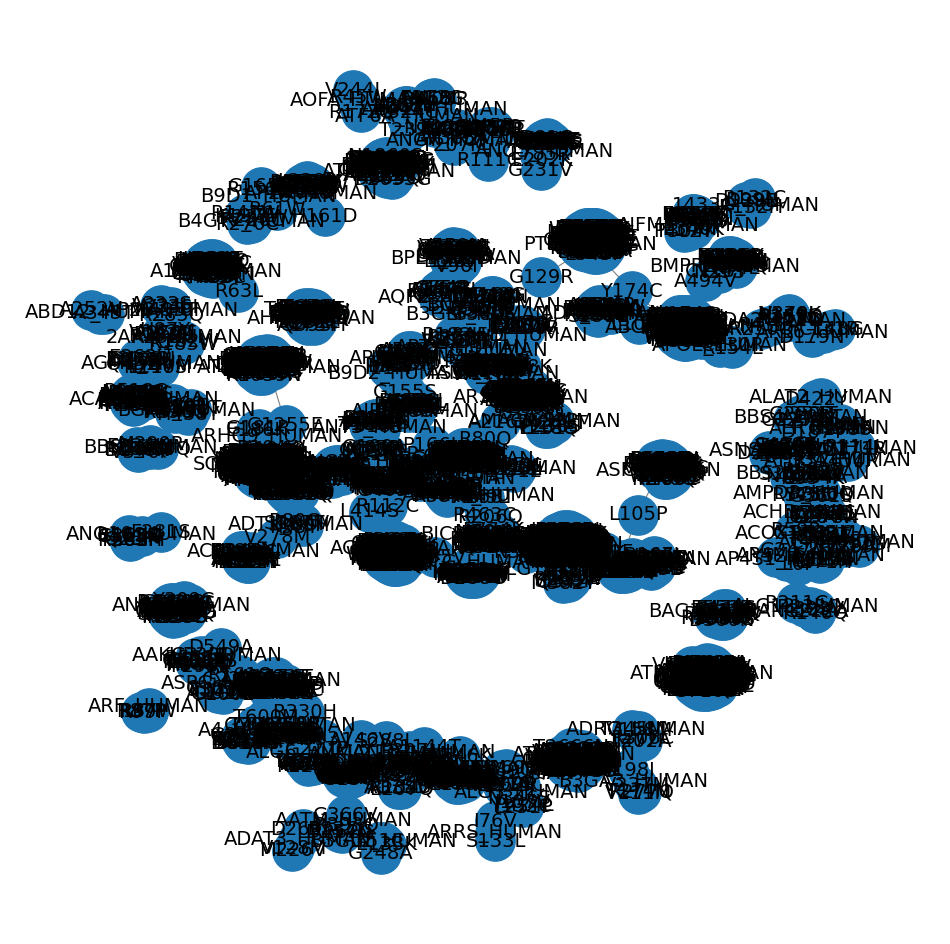

In [26]:
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()


In [48]:
interactions = {}
for x in G.nodes:
    interactions[x] = len(G[x])
s = pd.Series(interactions, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)